In [1]:
import geopandas as gpd
import numpy as np

import pygmo as pg

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

In [2]:
n_sensors = 60

## Load Data

Processed in population_data.ipynb notebook.

In [3]:
tyne_oa = gpd.read_file("../data/processed/tyne_oa")
tyne_oa.head()

oa11cd    lad11cd           X           Y  Population  \
0  E00042042  E08000021  421259.393  564639.754         310   
1  E00042043  E08000021  420448.616  564819.213         304   
2  E00042044  E08000021  420509.207  564622.209         246   
3  E00042045  E08000021  421551.722  564088.460         201   
4  E00042046  E08000021  422116.597  563648.529         424   

                                            geometry  
0  POLYGON ((421301.772 564928.429, 421301.755 56...  
1  POLYGON ((420572.364 564892.821, 420572.312 56...  
2  POLYGON ((420492.559 564780.806, 420492.590 56...  
3  POLYGON ((421543.715 563955.116, 421542.251 56...  
4  POLYGON ((422650.214 563568.422, 422650.020 56...

In [4]:
print(tyne_oa.X.min(), tyne_oa.X.max())
print(tyne_oa.Y.min(), tyne_oa.Y.max())

413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


In [5]:
populations = tyne_oa["Population"]

## Calculate Distances Between Output Areas

In [6]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [7]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


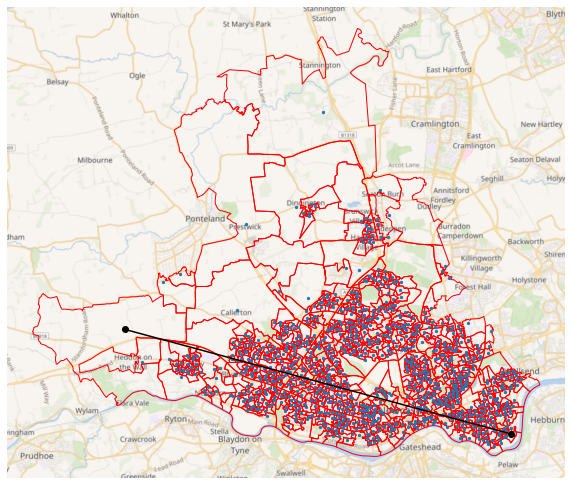

In [8]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "satisfaction"

Satisfaction at any output area due to a sensor placed in any other output area.

In [9]:
def distance_to_satisfaction(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_satisfaction = np.vectorize(distance_to_satisfaction)

Text(0, 0.5, 'satisfaction')

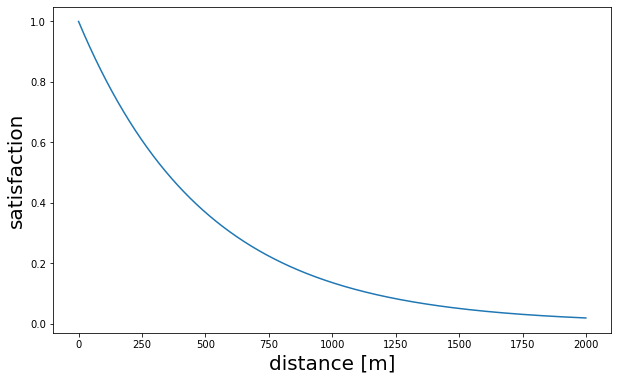

In [10]:
theta = 500

d = np.arange(0, 2000)
plt.figure(figsize=(10,6))
plt.plot(d, distance_to_satisfaction(d, theta=theta))
plt.xlabel("distance [m]", fontsize=20)
plt.ylabel("satisfaction", fontsize=20)

#plt.tight_layout()
#plt.savefig("../data/img/satisfaction_metric.png")

In [11]:
# "satisfaction" at each output area due to a sensor at any other output area
satisfaction = distance_to_satisfaction(distances, theta=theta)

Text(0.5, 1, 'Satisfaction due to sensor at E00042042')

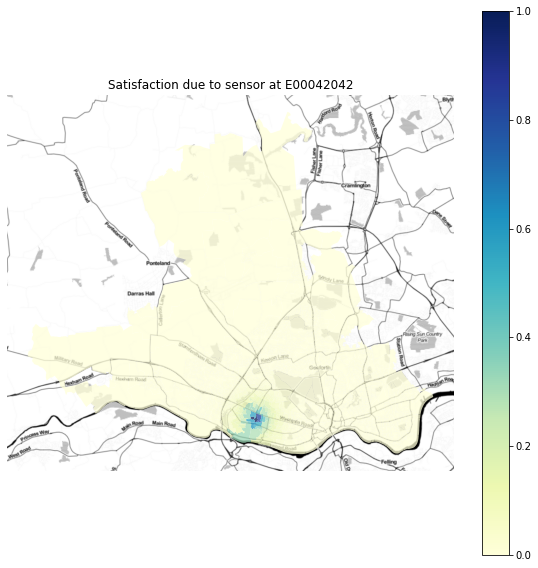

In [12]:
# satisfaction due to sensor at this output area index
sensor_idx = 0

tyne_oa["satisfaction"] = satisfaction[sensor_idx]

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("Satisfaction due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [13]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True,
                 save_path=None):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and satisfaction (shaded areas).
    """
    # only keep satisfactions due to output areas where a sensor is present
    mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

    # satisfaction at each output area = satisfaction due to nearest sensor
    max_mask_sat = np.max(mask_sat, axis=1)

    # population weighted average satisfaction
    avg_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
    
    tyne_oa["satisfaction"] = max_mask_sat

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="satisfaction",
                      alpha=0.75,
                      cmap="YlGn", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, satisfaction = {:.2f}".format(sensors.sum(), avg_satisfaction),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)
        
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

## Baseline 1: place sensors in output areas with largest population

Output areas with sensors: ['E00042061' 'E00042062' 'E00042081' 'E00042104' 'E00042147' 'E00042187'
 'E00042228' 'E00042262' 'E00042265' 'E00042266' 'E00042267' 'E00042272'
 'E00042273' 'E00042280' 'E00042299' 'E00042357' 'E00042406' 'E00042439'
 'E00042448' 'E00042450' 'E00042457' 'E00042459' 'E00042476' 'E00042491'
 'E00042580' 'E00042600' 'E00042609' 'E00042643' 'E00042644' 'E00042653'
 'E00042669' 'E00042670' 'E00042672' 'E00042673' 'E00042679' 'E00042717'
 'E00042733' 'E00042820' 'E00042825' 'E00042826' 'E00042874' 'E00042877'
 'E00042899' 'E00042900' 'E00042901' 'E00043549' 'E00043567' 'E00175551'
 'E00175554' 'E00175559' 'E00175564' 'E00175572' 'E00175574' 'E00175578'
 'E00175583' 'E00175584' 'E00175591' 'E00175593' 'E00175597' 'E00175598']


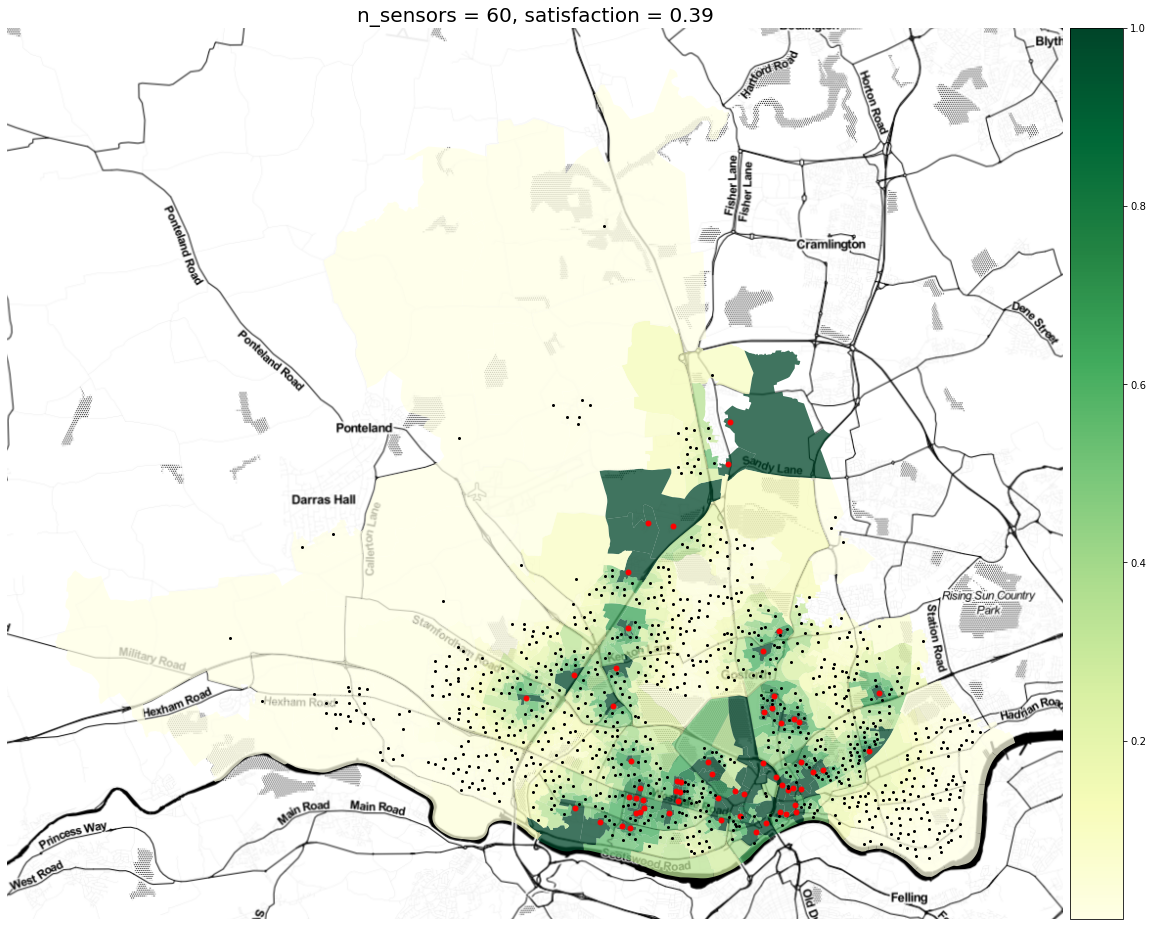

In [14]:
sensors = np.zeros((len(tyne_oa)))

top_idx = tyne_oa["Population"].sort_values(ascending=False).head(n_sensors).index

sensors[top_idx] = 1

plot_sensors(sensors)

## Baseline 2: Place sensors in random output areas

Output areas with sensors: ['E00042088' 'E00042106' 'E00042121' 'E00042135' 'E00042137' 'E00042147'
 'E00042156' 'E00042219' 'E00042222' 'E00042247' 'E00042287' 'E00042293'
 'E00042296' 'E00042331' 'E00042347' 'E00042348' 'E00042357' 'E00042359'
 'E00042366' 'E00042382' 'E00042386' 'E00042407' 'E00042425' 'E00042443'
 'E00042467' 'E00042469' 'E00042518' 'E00042549' 'E00042552' 'E00042557'
 'E00042564' 'E00042601' 'E00042610' 'E00042612' 'E00042634' 'E00042637'
 'E00042653' 'E00042669' 'E00042686' 'E00042712' 'E00042713' 'E00042715'
 'E00042721' 'E00042750' 'E00042754' 'E00042852' 'E00042871' 'E00042895'
 'E00042899' 'E00042915' 'E00043533' 'E00043569' 'E00175557' 'E00175584'
 'E00175594']


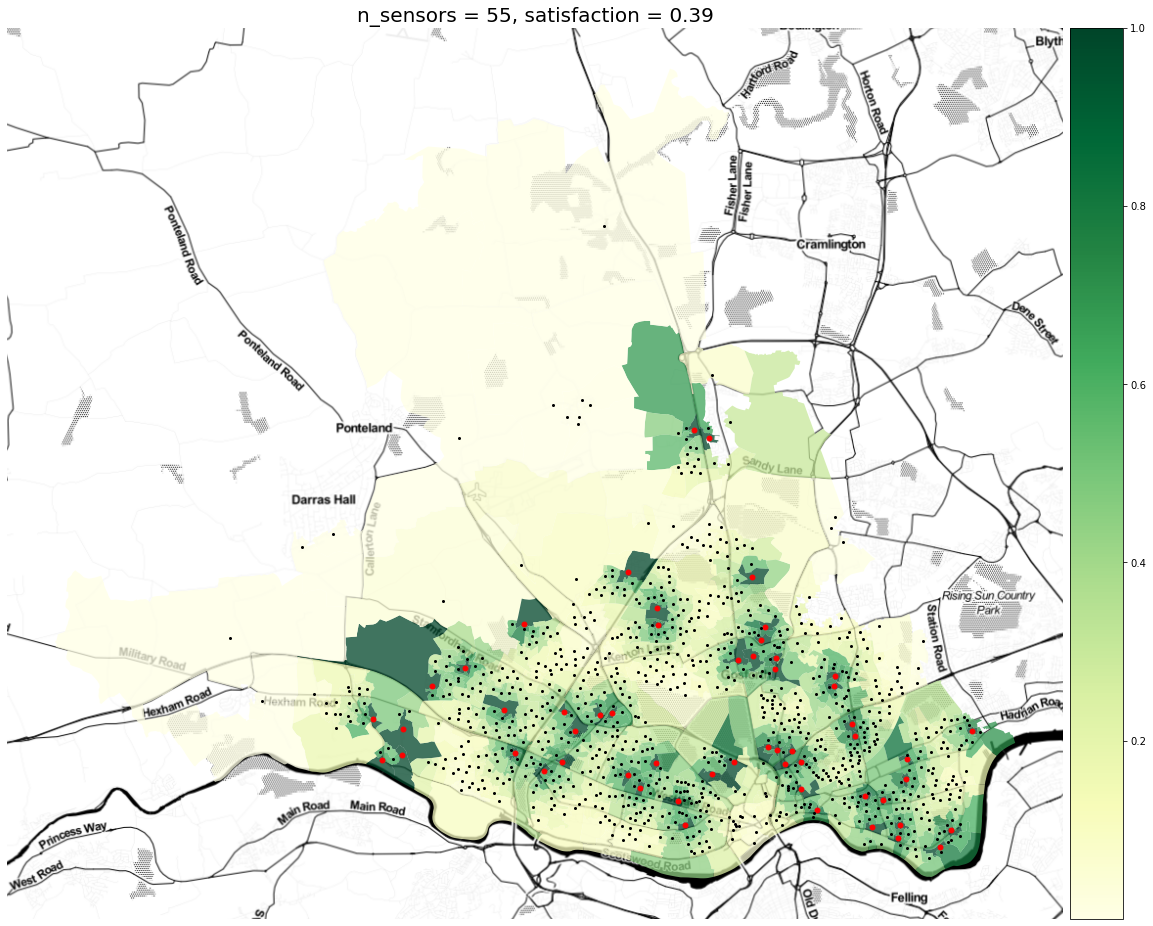

In [15]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

plot_sensors(sensors)

## Greedy: Place sensors one by one in the place that maximises total satisfaction

Placing sensor 1 out of 60 ... satisfaction = 0.04
Placing sensor 2 out of 60 ... satisfaction = 0.08
Placing sensor 3 out of 60 ... satisfaction = 0.10
Placing sensor 4 out of 60 ... satisfaction = 0.12
Placing sensor 5 out of 60 ... satisfaction = 0.15
Placing sensor 6 out of 60 ... satisfaction = 0.17
Placing sensor 7 out of 60 ... satisfaction = 0.19
Placing sensor 8 out of 60 ... satisfaction = 0.21
Placing sensor 9 out of 60 ... satisfaction = 0.22
Placing sensor 10 out of 60 ... satisfaction = 0.23
Placing sensor 11 out of 60 ... satisfaction = 0.24
Placing sensor 12 out of 60 ... satisfaction = 0.26
Placing sensor 13 out of 60 ... satisfaction = 0.27
Placing sensor 14 out of 60 ... satisfaction = 0.28
Placing sensor 15 out of 60 ... satisfaction = 0.29
Placing sensor 16 out of 60 ... satisfaction = 0.30
Placing sensor 17 out of 60 ... satisfaction = 0.31
Placing sensor 18 out of 60 ... satisfaction = 0.32
Placing sensor 19 out of 60 ... satisfaction = 0.33
Placing sensor 20 out

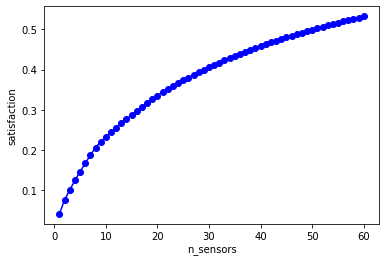

In [16]:
sensors = np.zeros((len(tyne_oa)))
save_plots = False
satisfaction_history = []
for s in range(n_sensors):
    # greedily add sensors
    print("Placing sensor", s+1, "out of", n_sensors, "... ", end='')
    
    best_satisfaction = 0
    best_sensors = sensors.copy()
    
    for oa in range(len(tyne_oa)):
        # try adding sensor at each output area
        
        if sensors[oa] == 1:
            # already have a sensor here, so skip to next
            continue
        
        else:
            new_sensors = sensors.copy()
            new_sensors[oa] = 1
            
            # only keep satisfactions due to output areas where a sensor is present
            mask_sat = np.multiply(satisfaction, new_sensors[np.newaxis, :])

            # satisfaction at each output area = satisfaction due to nearest sensor
            max_mask_sat = np.max(mask_sat, axis=1)
            
            # Avg satisfaction = population weighted sum across all output areas
            new_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
            
            if new_satisfaction > best_satisfaction:
                # this output area is the best site for next sensor found so far
                best_sensors = new_sensors.copy()
                best_satisfaction = new_satisfaction
            
    sensors = best_sensors.copy()
    satisfaction_history.append(best_satisfaction)
    print("satisfaction = {:.2f}".format(best_satisfaction))
    if save_plots:
        plot_sensors(sensors,
                     save_path="../data/img/nsensors_{:03d}.png".format(s+1),
                     print_sensors=False)
        plt.close('all')

print("DONE!")
print("Average satisfaction: {:.2f}".format(best_satisfaction))
plt.plot(range(1,n_sensors+1), satisfaction_history, '-bo')
plt.xlabel("n_sensors")
plt.ylabel("satisfaction")
if save_plots:
    plt.savefig("../data/img/satisfaction.png", dpi=300)

Output areas with sensors: ['E00042043' 'E00042062' 'E00042080' 'E00042084' 'E00042107' 'E00042151'
 'E00042160' 'E00042173' 'E00042183' 'E00042189' 'E00042214' 'E00042243'
 'E00042255' 'E00042267' 'E00042287' 'E00042299' 'E00042305' 'E00042316'
 'E00042332' 'E00042349' 'E00042381' 'E00042391' 'E00042419' 'E00042429'
 'E00042438' 'E00042447' 'E00042460' 'E00042494' 'E00042521' 'E00042559'
 'E00042570' 'E00042575' 'E00042580' 'E00042600' 'E00042621' 'E00042637'
 'E00042653' 'E00042661' 'E00042662' 'E00042704' 'E00042707' 'E00042718'
 'E00042724' 'E00042746' 'E00042778' 'E00042791' 'E00042820' 'E00042829'
 'E00042832' 'E00042846' 'E00042877' 'E00042878' 'E00042886' 'E00042921'
 'E00043544' 'E00175578' 'E00175591' 'E00175593' 'E00175598' 'E00175603']


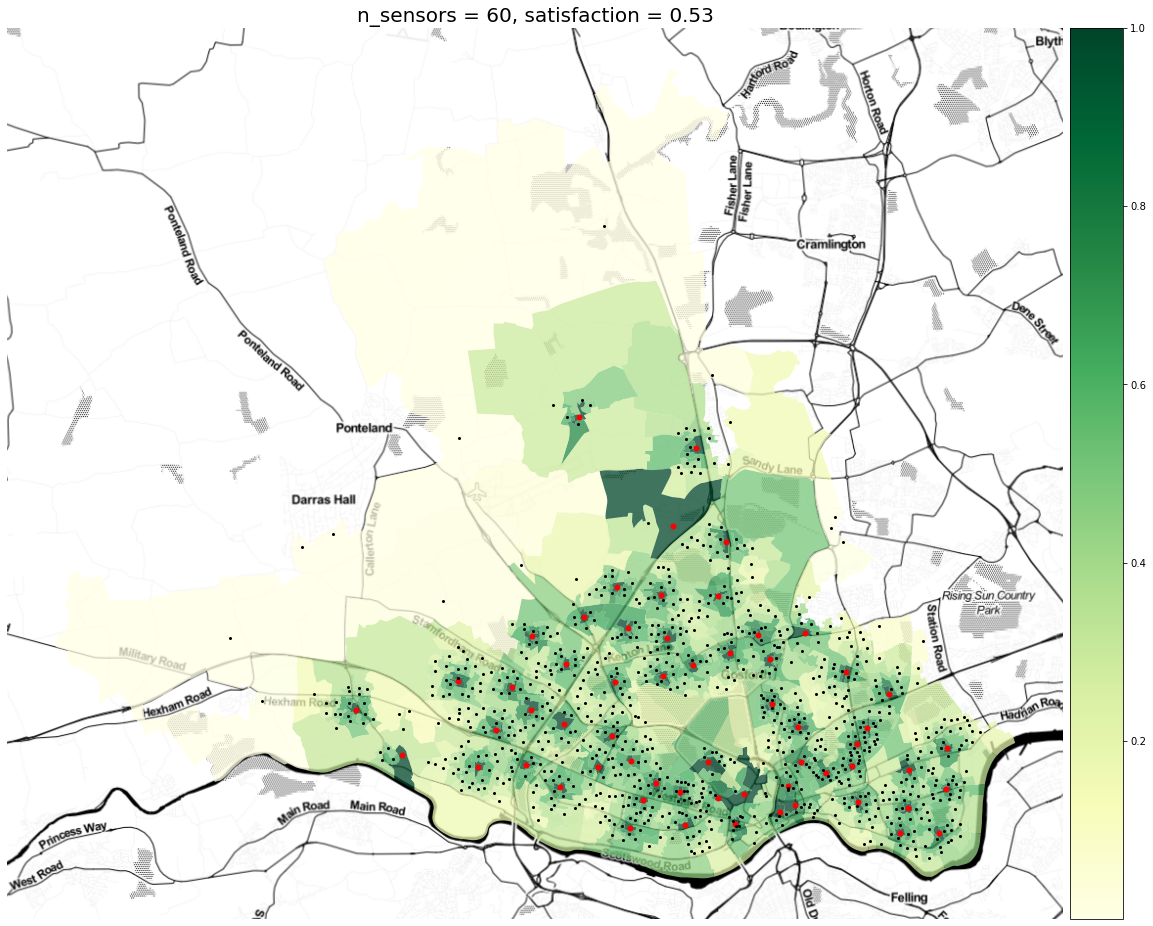

In [17]:
plot_sensors(sensors)

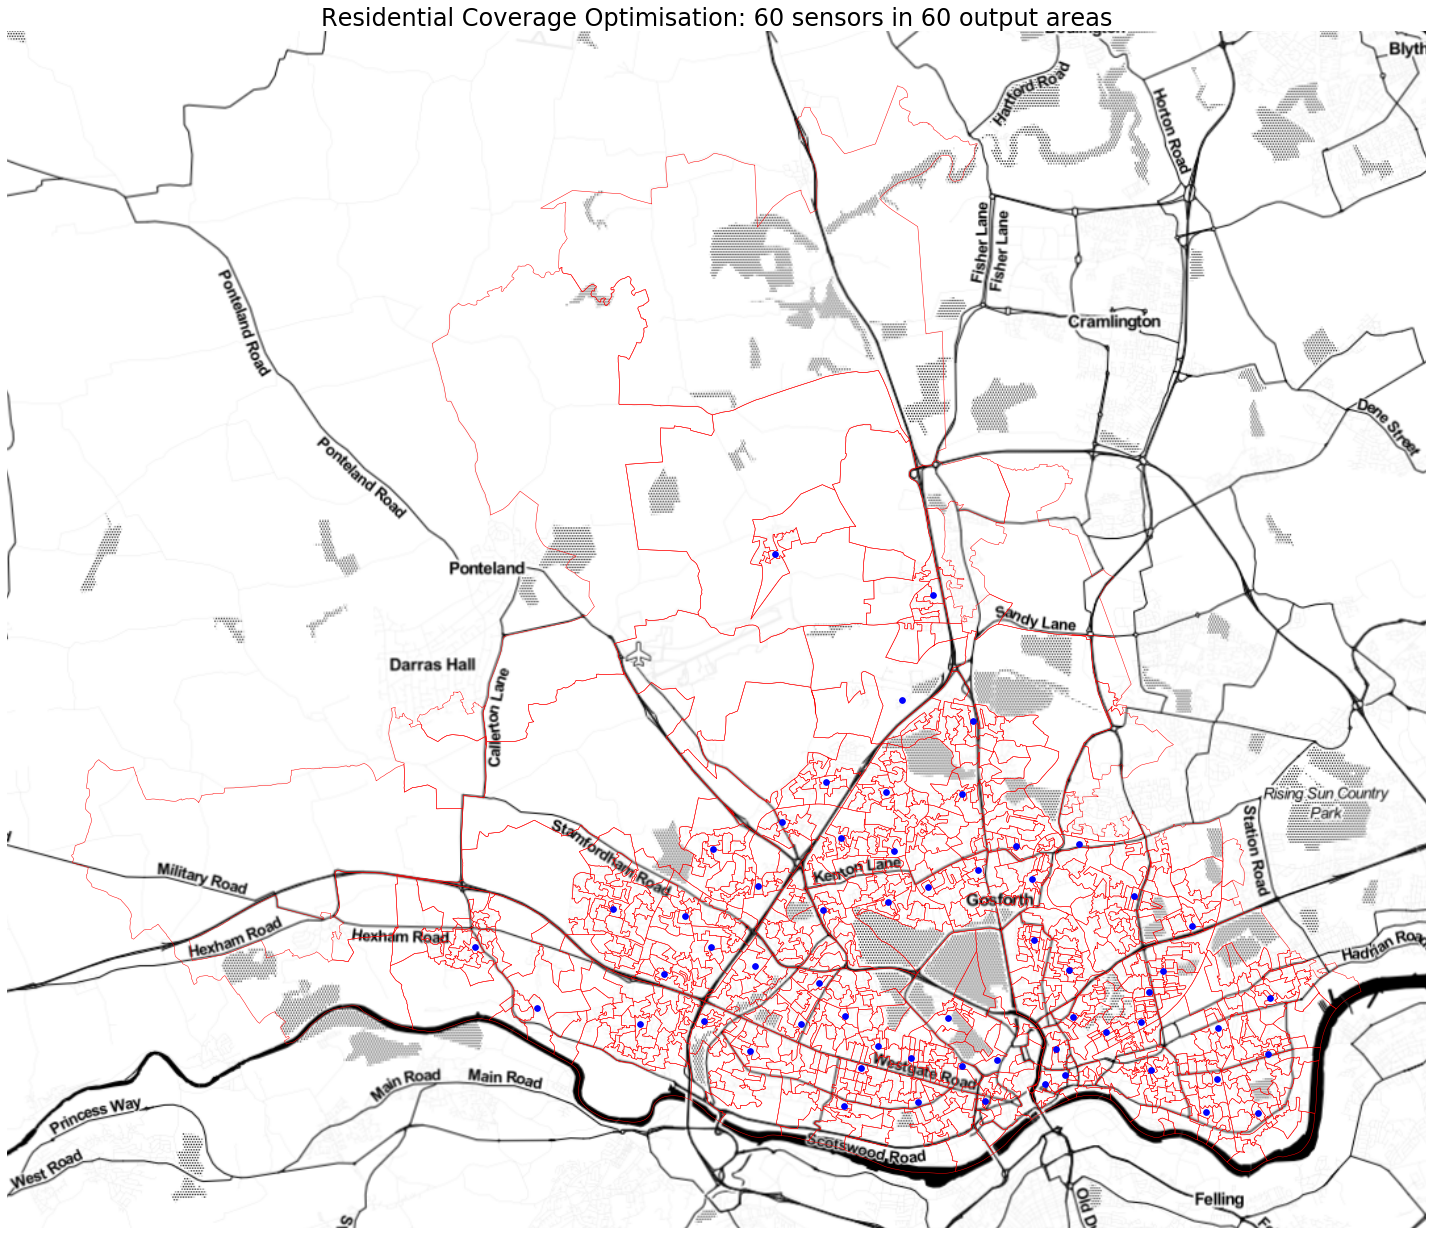

In [18]:
ax = tyne_oa.plot(figsize=(20,20), facecolor='none', edgecolor='red', linewidth=0.5)

ctx.add_basemap(ax,
                #url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa[sensors == 1]["X"]
y = tyne_oa[sensors == 1]["Y"]
ax.scatter(x, y, s=32, color='b')

plt.title("Residential Coverage Optimisation: {} sensors in {} output areas".format(n_sensors, n_sensors),
          fontsize=24)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("../data/img/opt_sensors.png", dpi=300)

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [18]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=10, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
        self.satisfaction = self.distance_to_satisfaction(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep satisfactions due to output areas where a sensor is present
        mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_mask_sat = np.max(mask_sat, axis=1)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_mask_sat).sum() / self.populations.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [19]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [20]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 2156490117 881227076 2460592086 2928388775 3790577693 1762408923 2310962440 3965169401 1813107370 326279296 1738396298 3166532578 2229376876 3003948147 1456026019 2623424249 4195046423 1929568245 4188532566 3316181404 3624092367 3684468369 2932029872 415499601 4251283981 1232174495 3444710768 1162684794 2835427491 2430949538 3544815422 2627948592 2075616730 567960200 1268492234 1539429946 2931562603 2418332306 354820854 2105241909 2578742700 322548687 3047602133 2651428606 3967380888 2865574228 3551886620 644412522 3105564674 2820589617 3400353617 1019610509 2515772885 3384900872 881735821 3761947864 2961563039 2478076970 3849534466 1100625312 3421589953 294047431

In [21]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.79966398 348.        ]
n_sensors 408.0
min sensors at location 0.0
max sensors at location 1.0


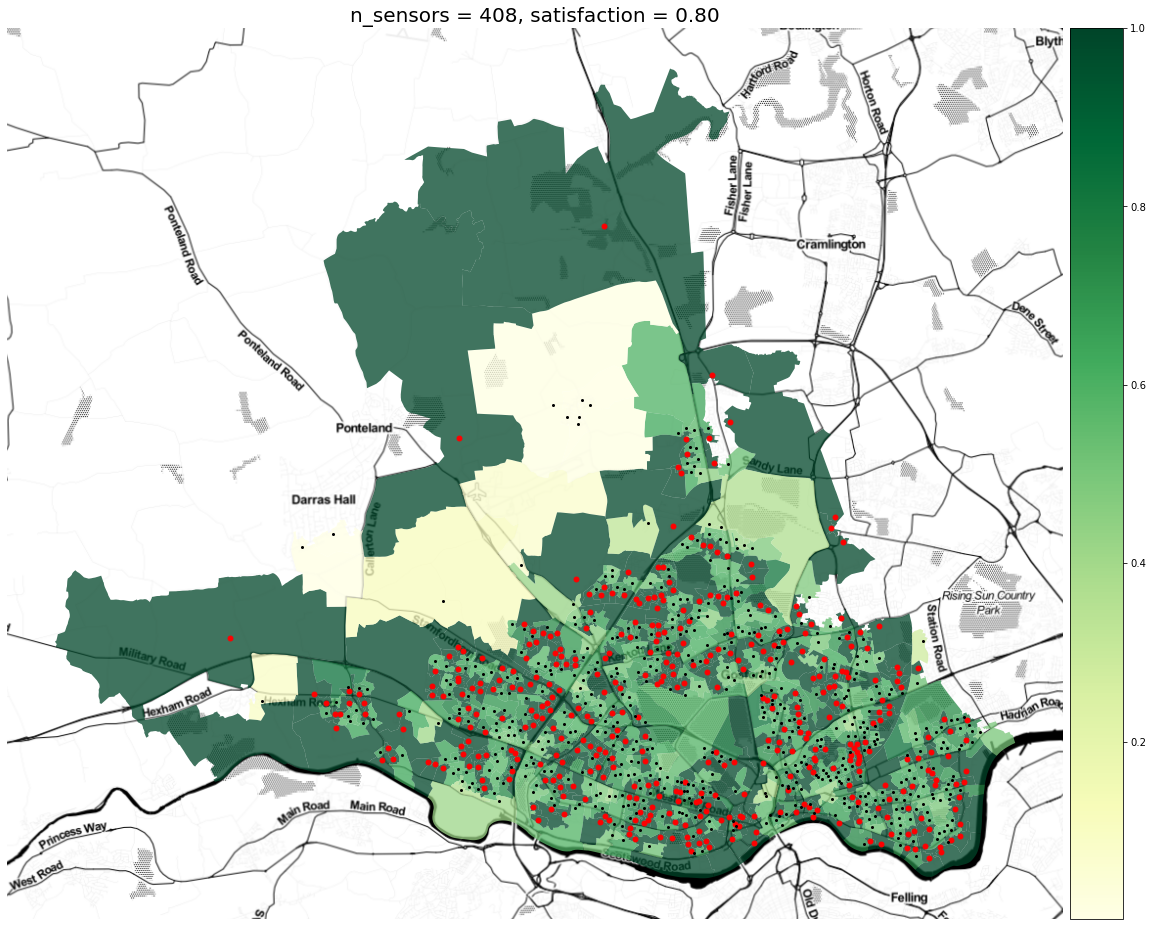

In [22]:
plot_sensors(pop.champion_x, print_sensors=False)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [27]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=20, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        self.theta = theta
        
        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        
        # convert 1D sensors vector into 2D array of X,Y coordinates
        sensors = sensors.reshape(self.n_sensors, 2)
        
        # calculate distance between sensors and output area centroids
        distances = self.calc_distances(sensors, centroids)

        # convert distances to satisfaction values
        # (satisfaction at each output area due to each sensor)
        satisfaction = self.distance_to_satisfaction(distances, theta=self.theta)
        

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_sat = np.max(satisfaction, axis=0)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_sat).sum() / self.populations.sum()

        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        min_xy = self.centroids.min(axis=0)
        max_xy = self.centroids.max(axis=0)
        
        return (list(min_xy)*self.n_sensors,
                list(max_xy)*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def calc_distances(self, sensors, centroids):
        """distance between sensor locations and output area centroids"""
        dist_sq = np.sum((sensors[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                         axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [28]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			120
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 120
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [29]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 695782220 2693259517 3355261853 3038909273 2655671787 3769406962 3320586523 2072438399 1661230526 2333946724 4073774408 1138848162 1295454299 1492098447 2294032148 4240454077 379866630 2260598383 3340285459 2157864035 752649049 3636032306 2452007787 1457246596 3195852433 3625603864 43596993 490684736 748682844 4274165353 2049577456 3754560820 4232750547 3302996785 2647694556 3646075321 1389537414 4177378408 1356699997 2147728755 1542600381 3036558421 2494444925 3990164038 2008687205 4187166113 487144216 585902247 3112069395 3767569638 1789993867 346939301 4006316365 3421104635 2806449934 1126118387 2981757106 3985667497 4170999372 3902645350 1039067413 2240885382 

In [30]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 10100
g evals 0
champion f [-0.35117506]
sensors [422856.97857781 564623.99326617 418097.21008797 571936.99030472
 418697.77350673 566512.62334505 415879.20483077 564600.24252106
 423711.46742935 570726.11931836 422205.28286649 564397.57078256
 421489.29324313 569658.64484101 425664.22788543 567982.96781283
 423232.88849865 568388.0427849  421947.65719377 567208.2446516
 427026.61635892 573580.86939874 427013.19552717 564388.19814997
 416818.82830687 564669.59984389 420638.67455717 565840.89063695
 422940.94440603 576721.55482606 422574.72687817 569372.32468746
 415195.5976354  573044.0839965  420627.27716058 567572.03056074
 417629.64967813 574713.25294956 424528.16094792 567193.54134959
 426393.53731094 564964.50767348 428888.16741831 564749.09625847
 422470.88542553 564863.81880839 423778.41292525 564432.35556296
 427136.74704023 566007.10364527 421750.23462169 567856.6956429
 425175.84611473 565900.44452375 428661.98537549 566617.24550734
 413917.25948019 566445.75210897 41

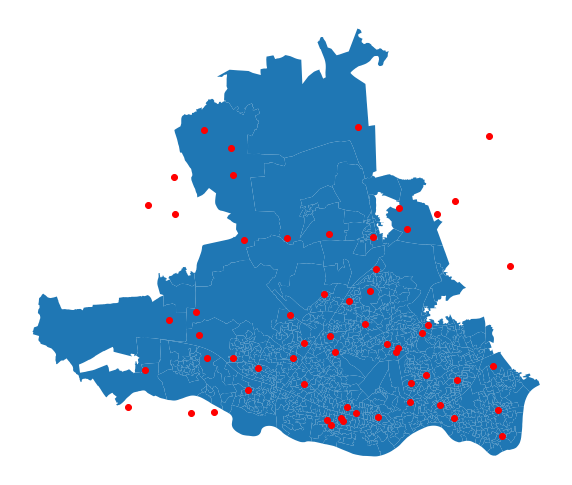

In [31]:
ax = tyne_oa.plot(figsize=(10,10))
ax.set_axis_off()

sensors = pop.champion_x
sensors = sensors.reshape(n_sensors, 2)
sensors_x = sensors[:, 0]
sensors_y = sensors[:, 1]
ax.scatter(sensors_x,sensors_y, color='r')

## MIP

In [28]:
from mip.model import *

Using Python-MIP package version 1.6.4


In [29]:
m = Model(sense=MAXIMIZE)

# sensors: yes/no at each output area
x = [m.add_var(var_type=BINARY) for i in range(len(populations))]

# sum of sensors vector should equal number of sensors
m.add_constr( xsum(x[i] for i in range(len(populations))) == n_sensors,
             "constraint_n_sensors")


# objective function
def obj_function(sensors):
    sensors = np.array([sensor.x if sensor.x is not None else 0 for sensor in sensors])
    
    mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

    # satisfaction at each output area = satisfaction due to nearest sensor
    max_mask_sat = np.max(mask_sat, axis=1)

    # Total population-weighted satisfaction of solution = our objective
    return (populations * max_mask_sat).sum() / populations.sum()

m.objective = maximize(obj_function(x))


AttributeError: 'numpy.float64' object has no attribute 'sense'

In [ ]:
x[0].

In [ ]:
len(populations)

In [ ]:
centroids.shape

In [ ]:
t = np.array(range(40))

In [ ]:
t = t.reshape(20,2)

In [ ]:
t

In [ ]:
x=np.sum((t[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)
x.shape

In [ ]:
np.max(x, axis=0).shape

In [ ]:
min_xy = centroids.min(axis=0)
max_xy = centroids.max(axis=0)
min_xy

In [ ]:
list(min_xy)*n_sensors

In [ ]:
tyne_oa.crs

In [ ]:
t = [0,0,0,1,0]
[i for i in t if i==1]

In [ ]:
tyne_oa

## scipy optimize

In [ ]:
prob =         population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)

In [ ]:
def temp1(x):
    q1 = prob.fitness(x)
    print(q1)
    return q1[0]

In [ ]:
413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


In [ ]:
from scipy import optimize

points = optimize.minimize(temp1, sensors.reshape(40,))

In [ ]:
points = optimize.minimize(temp1,[(413067.0710000005+429849.7170000002)/2 if x%2==0 else (563224.0130000003+577386.1339999996)/2  for x in range(40)])

In [ ]:
points1 = optimize.differential_evolution(temp1,[[413067.0710000005,429849.7170000002] if x%2==0 else [563224.0130000003, 577386.1339999996]  for x in range(40)])

In [ ]:
temp1(sensors.reshape(40,))

In [ ]:
points

In [ ]:
satisfaction

In [ ]:
max_sat.shape

In [ ]:
fitness_sensors

In [ ]:
centroids.min(axis=0)

In [ ]:
centroids.max(axis=0)

In [ ]:
min_xy = centroids.min(axis=0)
max_xy = centroids.max(axis=0)
        
(list(min_xy)*n_sensors, list(max_xy)*n_sensors)
    

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9a206a7f0>)

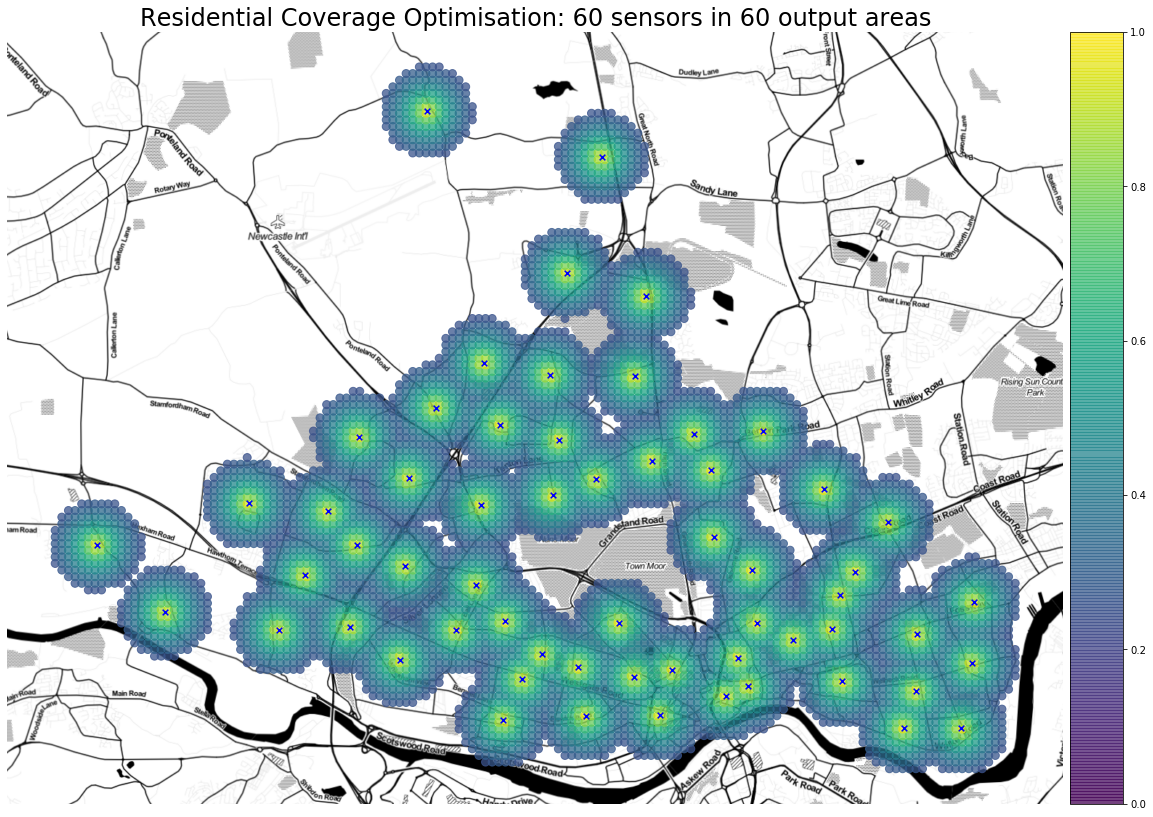

In [19]:
from spineq.plotting import plot_coverage_grid

sens_xy = np.array([tyne_oa[sensors==1]["X"],
                    tyne_oa[sensors==1]["Y"]]).T
bounds = tyne_oa["geometry"].bounds
xlim = (bounds["minx"].min(), bounds["maxx"].max())
ylim =(bounds["miny"].min(), bounds["maxy"].max())
title = "Residential Coverage Optimisation: {} sensors in {} output areas".format(
            n_sensors, 
            n_sensors)
save_path = "../data/img/resopt_coverage.png"

plot_coverage_grid(sens_xy, xlim, ylim, title=title, save_path=save_path)

In [21]:
satisfaction.shape

(952, 952)

In [22]:
950*950

902500

In [24]:
tyne_oa

oa11cd    lad11cd           X           Y  Population  \
0    E00042042  E08000021  421259.393  564639.754         310   
1    E00042043  E08000021  420448.616  564819.213         304   
2    E00042044  E08000021  420509.207  564622.209         246   
3    E00042045  E08000021  421551.722  564088.460         201   
4    E00042046  E08000021  422116.597  563648.529         424   
..         ...        ...         ...         ...         ...   
947  E00175601  E08000021  427530.167  567089.407         140   
948  E00175602  E08000021  421582.146  567303.241         240   
949  E00175603  E08000021  421677.102  567157.528         288   
950  E00175604  E08000021  421727.237  567363.103         245   
951  E00175605  E08000021  423583.150  571844.330         195   

                                              geometry  satisfaction  
0    POLYGON ((421301.772 564928.429, 421301.755 56...      0.283315  
1    POLYGON ((420572.364 564892.821, 420572.312 56...      1.000000  
2    POLYGON ((420492.559 564780.806, 420492.590 56...      0.662177  
3    POLYGON ((421543.715 563955.116, 421542.251 56...      0.369151  
4    POLYGON ((422650.214 563568.422, 422650.020 56...      0.577697  
..                                                 ...           ...  
947  POLYGON ((427639.103 567072.346, 427638.375 56...      0.501435  
948  POLYGON ((421579.281 567363.000, 421581.156 56...      0.706209  
949  POLYGON ((421751.129 567264.313, 421719.882 56...      1.000000  
950  POLYGON ((421885.267 567295.251, 421882.409 56...      0.654948  
951  POLYGON ((423589.243 571950.505, 423607.131 57...      0.315274  

[952 rows x 7 columns]